In [367]:
import pyspark as ps
import pandas as pd
import numpy as np

In [59]:
import matplotlib.pyplot as plt

In [297]:
from datetime import datetime, date, time

In [2]:
spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("df case study") \
            .getOrCreate()
sc = spark.sparkContext

In [116]:
results_df = spark.read.csv('data/2019-Ironman-World-Championship-Results.csv',
                            header=True,
                            quote='"',
                            sep=',',
                            inferSchema=True)

In [92]:
results_df.show()

+---+-------------------+-------+------+--------+--------+--------+--------+--------+-------------+-----------+------------+--------+--------+
|BIB|               Name|Country|Gender|Division|    Swim|    Bike|     Run| Overall|Division Rank|Gender Rank|Overall Rank|      T1|      T2|
+---+-------------------+-------+------+--------+--------+--------+--------+--------+-------------+-----------+------------+--------+--------+
|  4|       Frodeno, Jan|    DEU|  Male|    MPRO|00:47:31|04:16:02|02:42:43|07:51:13|            1|          1|           1|00:01:58|00:02:59|
|  6|     O'donnell, Tim|    USA|  Male|    MPRO|00:47:38|04:18:11|02:49:45|07:59:41|            2|          2|           2|00:02:01|00:02:06|
|  5|  Kienle, Sebastian|    DEU|  Male|    MPRO|00:52:17|04:15:04|02:49:56|08:02:04|            3|          3|           3|00:02:12|00:02:35|
| 14|       Hoffman, Ben|    USA|  Male|    MPRO|00:51:01|04:24:01|02:43:08|08:02:52|            4|          4|           4|00:02:25|00:02:17|

In [117]:
results_df.printSchema()

root
 |-- BIB: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Division: string (nullable = true)
 |-- Swim: string (nullable = true)
 |-- Bike: string (nullable = true)
 |-- Run: string (nullable = true)
 |-- Overall: string (nullable = true)
 |-- Division Rank: string (nullable = true)
 |-- Gender Rank: string (nullable = true)
 |-- Overall Rank: string (nullable = true)
 |-- T1: string (nullable = true)
 |-- T2: string (nullable = true)



In [118]:
results_df.toPandas()

,BIB,Name,Country,Gender,Division,Swim,Bike,Run,Overall,Division Rank,Gender Rank,Overall Rank,T1,T2
0,4,"Frodeno, Jan",DEU,Male,MPRO,00:47:31,04:16:02,02:42:43,07:51:13,1,1,1,00:01:58,00:02:59
1,6,"O'donnell, Tim",USA,Male,MPRO,00:47:38,04:18:11,02:49:45,07:59:41,2,2,2,00:02:01,00:02:06
2,5,"Kienle, Sebastian",DEU,Male,MPRO,00:52:17,04:15:04,02:49:56,08:02:04,3,3,3,00:02:12,00:02:35
3,14,"Hoffman, Ben",USA,Male,MPRO,00:51:01,04:24:01,02:43:08,08:02:52,4,4,4,00:02:25,00:02:17
4,11,"Wurf, Cameron",AUS,Male,MPRO,00:52:25,04:14:44,02:55:03,08:06:41,5,5,5,00:02:07,00:02:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2429,544,"Sudut, Martin",USA,Male,M65-69,None,None,None,None,DNS,DNS,DNS,None,None
2430,471,"Bourdillon, Patrick",USA,Male,M70-74,None,None,None,None,DNS,DNS,DNS,None,None
2431,476,"Evenson, Even",USA,Male,M70-74,None,None,None,None,DNS,DNS,DNS,None,None
2432,454,"Cooper, D. Mark",USA,Male,M75-79,None,None,None,None,DNS,DNS,DNS,None,None


In [119]:
male_results = results_df[results_df['Gender'] == 'Male'].toPandas()
male_results

,BIB,Name,Country,Gender,Division,Swim,Bike,Run,Overall,Division Rank,Gender Rank,Overall Rank,T1,T2
0,4,"Frodeno, Jan",DEU,Male,MPRO,00:47:31,04:16:02,02:42:43,07:51:13,1,1,1,00:01:58,00:02:59
1,6,"O'donnell, Tim",USA,Male,MPRO,00:47:38,04:18:11,02:49:45,07:59:41,2,2,2,00:02:01,00:02:06
2,5,"Kienle, Sebastian",DEU,Male,MPRO,00:52:17,04:15:04,02:49:56,08:02:04,3,3,3,00:02:12,00:02:35
3,14,"Hoffman, Ben",USA,Male,MPRO,00:51:01,04:24:01,02:43:08,08:02:52,4,4,4,00:02:25,00:02:17
4,11,"Wurf, Cameron",AUS,Male,MPRO,00:52:25,04:14:44,02:55:03,08:06:41,5,5,5,00:02:07,00:02:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766,544,"Sudut, Martin",USA,Male,M65-69,None,None,None,None,DNS,DNS,DNS,None,None
1767,471,"Bourdillon, Patrick",USA,Male,M70-74,None,None,None,None,DNS,DNS,DNS,None,None
1768,476,"Evenson, Even",USA,Male,M70-74,None,None,None,None,DNS,DNS,DNS,None,None
1769,454,"Cooper, D. Mark",USA,Male,M75-79,None,None,None,None,DNS,DNS,DNS,None,None


In [137]:
# Convert DNS & DNF to 0
male_results.loc[male_results['Division Rank'] == 'DNS', 'Division Rank'] = 0
male_results

# Convert None in Swim, Bike, Run, Overall, T1, and T2 to 00:00:00
cols_to_clean = ['Swim', 'Bike', 'Run', 'Overall','T1', 'T2']
male_results[cols_to_clean] = male_results[cols_to_clean].apply(pd.to_datetime)

male_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1771 entries, 0 to 1770
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   BIB            1771 non-null   int32         
 1   Name           1771 non-null   object        
 2   Country        1770 non-null   object        
 3   Gender         1771 non-null   object        
 4   Division       1771 non-null   object        
 5   Swim           1709 non-null   datetime64[ns]
 6   Bike           1681 non-null   datetime64[ns]
 7   Run            1651 non-null   datetime64[ns]
 8   Overall        1649 non-null   datetime64[ns]
 9   Division Rank  1771 non-null   object        
 10  Gender Rank    1771 non-null   object        
 11  Overall Rank   1771 non-null   object        
 12  T1             1707 non-null   datetime64[ns]
 13  T2             1674 non-null   datetime64[ns]
dtypes: datetime64[ns](6), int32(1), object(7)
memory usage: 186.9+ KB


In [121]:
male_pro = male_results[male_results['Division'] == 'MPRO']

In [122]:
male_agegroup = male_results[male_results['Division'] != 'MPRO']

In [337]:
fem_results = results_df[results_df['Gender'] == 'Female'].toPandas()
fem_results

,BIB,Name,Country,Gender,Division,Swim,Bike,Run,Overall,Division Rank,Gender Rank,Overall Rank,T1,T2
0,3003,"Haug, Anne",DEU,Female,FPRO,00:54:09,04:50:17,02:51:07,08:40:10,1,1,32,00:02:02,00:02:35
1,3002,"Charles-barclay, Lucy",GBR,Female,FPRO,00:49:02,04:47:20,03:05:59,08:46:44,2,2,39,00:02:05,00:02:18
2,3006,"Crowley, Sarah",AUS,Female,FPRO,00:54:05,04:50:13,02:59:20,08:48:13,3,3,42,00:02:11,00:02:24
3,3021,"Philipp, Laura",DEU,Female,FPRO,00:59:03,04:45:04,03:02:11,08:51:42,4,4,48,00:02:27,00:02:57
4,3011,"Jackson, Heather",USA,Female,FPRO,00:59:12,04:46:45,03:04:17,08:54:44,5,5,52,00:02:17,00:02:13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,1383,"Ponce, Carolina",ECU,Female,F45-49,None,None,None,None,DNS,DNS,DNS,None,None
659,1404,"Trazzi, Barbara",ITA,Female,F45-49,None,None,None,None,DNS,DNS,DNS,None,None
660,1045,"Dunkle, Julie",USA,Female,F50-54,None,None,None,None,DNS,DNS,DNS,None,None
661,796,"Bellon, Veronique",FRA,Female,F55-59,None,None,None,None,DNS,DNS,DNS,None,None


In [340]:
# Convert DNS & DNF to 0
fem_results.loc[fem_results['Division Rank'] == 'DNS', 'Division Rank'] = 0
fem_results.loc[fem_results['Division Rank'] == 'DNF', 'Division Rank'] = 0

# Remove DQ == Disqualified 
fem_results.loc[fem_results['Division Rank'] == 'DQ', 'Division Rank'] = 0

In [342]:
fem_results['Division Rank'] = fem_results['Division Rank'].astype(int)
fem_results

,BIB,Name,Country,Gender,Division,Swim,Bike,Run,Overall,Division Rank,Gender Rank,Overall Rank,T1,T2
0,3003,"Haug, Anne",DEU,Female,FPRO,00:54:09,04:50:17,02:51:07,08:40:10,1,1,32,00:02:02,00:02:35
1,3002,"Charles-barclay, Lucy",GBR,Female,FPRO,00:49:02,04:47:20,03:05:59,08:46:44,2,2,39,00:02:05,00:02:18
2,3006,"Crowley, Sarah",AUS,Female,FPRO,00:54:05,04:50:13,02:59:20,08:48:13,3,3,42,00:02:11,00:02:24
3,3021,"Philipp, Laura",DEU,Female,FPRO,00:59:03,04:45:04,03:02:11,08:51:42,4,4,48,00:02:27,00:02:57
4,3011,"Jackson, Heather",USA,Female,FPRO,00:59:12,04:46:45,03:04:17,08:54:44,5,5,52,00:02:17,00:02:13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,1383,"Ponce, Carolina",ECU,Female,F45-49,None,None,None,None,0,DNS,DNS,None,None
659,1404,"Trazzi, Barbara",ITA,Female,F45-49,None,None,None,None,0,DNS,DNS,None,None
660,1045,"Dunkle, Julie",USA,Female,F50-54,None,None,None,None,0,DNS,DNS,None,None
661,796,"Bellon, Veronique",FRA,Female,F55-59,None,None,None,None,0,DNS,DNS,None,None


In [327]:
# Convert None in Swim, Bike, Run, Overall, T1, and T2 to datetime
# These need to be converted to time intervals NOT datetime (<- time stamp)
# pd.to_timedelta
cols_to_clean = ['Swim', 'Bike', 'Run', 'Overall','T1', 'T2']
fem_results[cols_to_clean] = fem_results[cols_to_clean].apply(pd.to_timedelta, unit='s')
fem_results.dtypes

BIB                        int32
Name                      object
Country                   object
Gender                    object
Division                  object
Swim             timedelta64[ns]
Bike             timedelta64[ns]
Run              timedelta64[ns]
Overall          timedelta64[ns]
Division Rank             object
Gender Rank               object
Overall Rank              object
T1               timedelta64[ns]
T2               timedelta64[ns]
dtype: object

In [328]:
fem_results

,BIB,Name,Country,Gender,Division,Swim,Bike,Run,Overall,Division Rank,Gender Rank,Overall Rank,T1,T2
0,3003,"Haug, Anne",DEU,Female,FPRO,00:54:09,04:50:17,02:51:07,08:40:10,1,1,32,00:02:02,00:02:35
1,3002,"Charles-barclay, Lucy",GBR,Female,FPRO,00:49:02,04:47:20,03:05:59,08:46:44,2,2,39,00:02:05,00:02:18
2,3006,"Crowley, Sarah",AUS,Female,FPRO,00:54:05,04:50:13,02:59:20,08:48:13,3,3,42,00:02:11,00:02:24
3,3021,"Philipp, Laura",DEU,Female,FPRO,00:59:03,04:45:04,03:02:11,08:51:42,4,4,48,00:02:27,00:02:57
4,3011,"Jackson, Heather",USA,Female,FPRO,00:59:12,04:46:45,03:04:17,08:54:44,5,5,52,00:02:17,00:02:13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,1383,"Ponce, Carolina",ECU,Female,F45-49,NaT,NaT,NaT,NaT,0,DNS,DNS,NaT,NaT
659,1404,"Trazzi, Barbara",ITA,Female,F45-49,NaT,NaT,NaT,NaT,0,DNS,DNS,NaT,NaT
660,1045,"Dunkle, Julie",USA,Female,F50-54,NaT,NaT,NaT,NaT,0,DNS,DNS,NaT,NaT
661,796,"Bellon, Veronique",FRA,Female,F55-59,NaT,NaT,NaT,NaT,0,DNS,DNS,NaT,NaT


In [343]:
fem_pro = fem_results[fem_results['Division'] == 'FPRO']
fem_pro

,BIB,Name,Country,Gender,Division,Swim,Bike,Run,Overall,Division Rank,Gender Rank,Overall Rank,T1,T2
0,3003,"Haug, Anne",DEU,Female,FPRO,00:54:09,04:50:17,02:51:07,08:40:10,1,1,32,00:02:02,00:02:35
1,3002,"Charles-barclay, Lucy",GBR,Female,FPRO,00:49:02,04:47:20,03:05:59,08:46:44,2,2,39,00:02:05,00:02:18
2,3006,"Crowley, Sarah",AUS,Female,FPRO,00:54:05,04:50:13,02:59:20,08:48:13,3,3,42,00:02:11,00:02:24
3,3021,"Philipp, Laura",DEU,Female,FPRO,00:59:03,04:45:04,03:02:11,08:51:42,4,4,48,00:02:27,00:02:57
4,3011,"Jackson, Heather",USA,Female,FPRO,00:59:12,04:46:45,03:04:17,08:54:44,5,5,52,00:02:17,00:02:13
5,3007,"Sali, Kaisa",FIN,Female,FPRO,00:59:14,04:53:53,02:57:18,08:55:33,6,6,55,00:02:11,00:02:57
6,3008,"Abraham, Corinne",GBR,Female,FPRO,01:02:46,04:51:15,02:59:28,08:58:38,7,7,63,00:02:31,00:02:38
7,3012,"Lester, Carrie",AUS,Female,FPRO,00:54:15,04:50:01,03:09:37,08:58:40,8,8,64,00:02:22,00:02:25
8,3023,"Bleymehl, Daniela",DEU,Female,FPRO,00:59:06,04:45:08,03:19:32,09:08:30,9,9,92,00:02:06,00:02:38
9,3009,"Corbin, Linsey",USA,Female,FPRO,00:59:09,05:00:25,03:03:50,09:09:06,10,10,94,00:02:55,00:02:47


In [264]:
fem_agegroup = fem_results[fem_results['Division'] != 'FPRO']

In [251]:
def plot_data(plot, data_df, var_to_plot, yaxis, title, xlabel, ylabel, fontsize=12):
    '''
    returns plot 
    '''
    fig, ax = plt.subplots(1, figsize=(10, 5))
    
    # select our plot type
    ax.plot(data_df, data_df[var_to_plot], data_df[yaxis])
    ax = data_df.plot(kind=plot, x=data_df[var_to_plot], y=data_df[yaxis])
    
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    return fig, ax

In [359]:
# Convert earlier with import !!!
fem_pro['Division Rank'].astype(int)
fem_pro['Swim'].sort_values()

1      00:49:02
61     00:49:08
243    00:54:00
634    00:54:02
635    00:54:03
2      00:54:05
32     00:54:07
0      00:54:09
11     00:54:10
612    00:54:13
7      00:54:15
636    00:54:17
12     00:54:20
240    00:54:21
28     00:58:58
25     00:59:01
19     00:59:02
3      00:59:03
22     00:59:03
10     00:59:04
31     00:59:05
8      00:59:06
20     00:59:07
9      00:59:09
637    00:59:10
21     00:59:12
4      00:59:12
23     00:59:14
18     00:59:14
5      00:59:14
638    01:01:17
15     01:02:44
6      01:02:46
611    01:02:49
51     01:04:32
27     01:04:34
13     01:04:36
14     01:04:38
69     01:08:16
33     01:09:17
17     01:15:24
311    01:51:02
Name: Swim, dtype: object

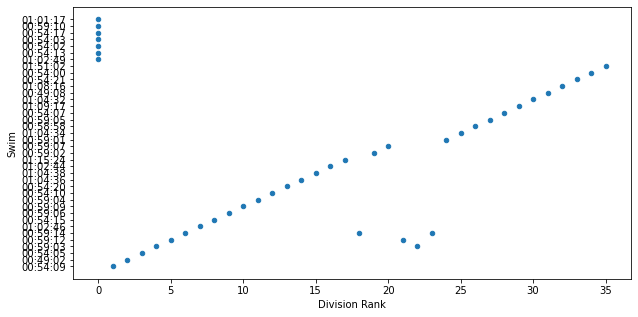

In [360]:
fig,ax = plt.subplots(1, figsize=(10,5))

fem_pro.plot(x='Division Rank', y='Swim', kind='scatter', ax=ax)
plt.show()

TypeError: no numeric data to plot

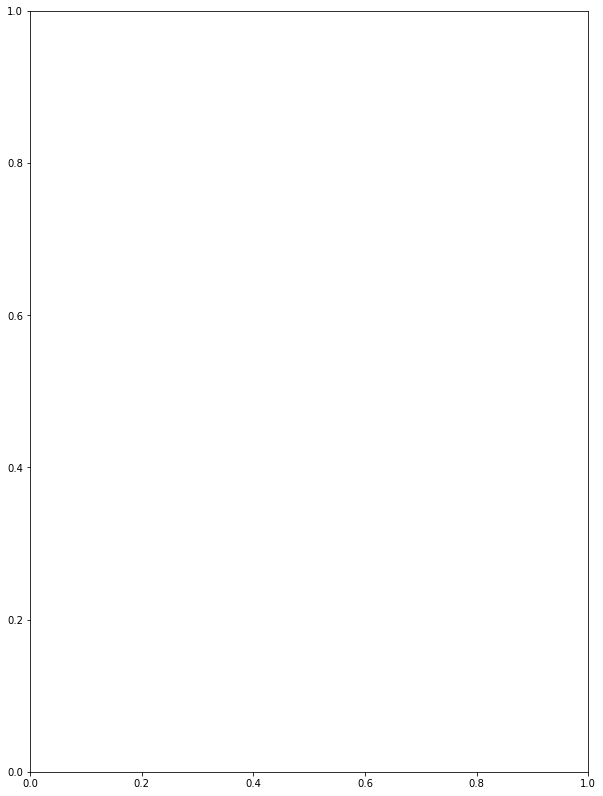

In [377]:
fig, ax = plt.subplots(figsize=(10,14))
fem_pro.sort_values('Swim').plot(x='Division Rank', y='Swim')

TypeError: 'value' must be an instance of str or bytes, not a int

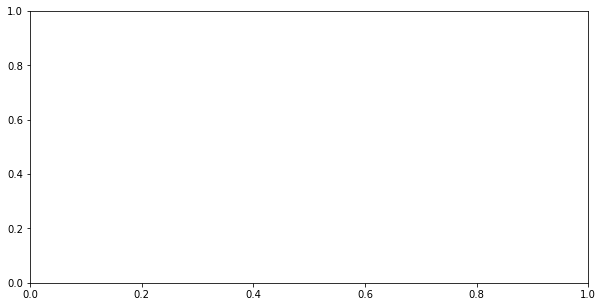

In [252]:
# Scatter Plot of Male Pro Swim times vs. Divison Rank

plot_data('scatter', fem_pro, 'Division Rank', 'Swim', title='Female Pro Swim times vs. Divison Rank', xlabel='Division Rank', ylabel='Swim Time')